In [1]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [2]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt

In [3]:

fname = join(os.getcwd(),'data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

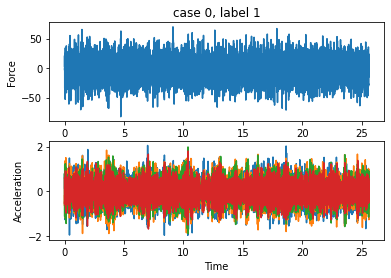

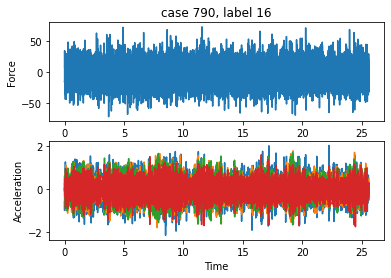

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [5]:
Ch5.shape

(8192, 850)

In [6]:
type(Ch2)

numpy.ndarray

In [7]:
from statsmodels.tsa.ar_model import AutoReg
model_order = 30

ar_coefficients = []

for channel_data in [Ch2, Ch3, Ch4, Ch5]:
    channel_ar_coefficients = []
    
    for i in range(channel_data.shape[1]):
        ar_model = AutoReg(channel_data[:, i], lags=model_order)
        ar_results = ar_model.fit()
        
        ar_coef = ar_results.params[1:]
        channel_ar_coefficients.append(ar_coef)
    
    channel_ar_coefficients = np.array(channel_ar_coefficients)
    ar_coefficients.append(channel_ar_coefficients)

ar_coefficients = np.concatenate(ar_coefficients, axis=1)
ar_coefficients.shape

(850, 120)

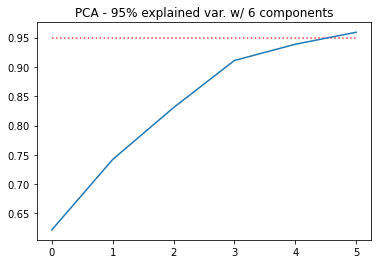

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca.fit(ar_coefficients)

principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

fig,ax = plt.subplots(figsize=(6,4))
ax.hlines(y=.95, xmin=0, xmax=5, colors='red', ls=':', alpha=0.75)
ax.plot(cumulative_variance_ratio)
plt.title('PCA - 95% explained var. w/ 6 components')
plt.show()

In [9]:
X2 = pca.transform(ar_coefficients)

In [10]:
np.shape(X2)

(850, 6)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_principal_components = scaler.fit_transform(X2)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(ar_coefficients,
                                                                         scaled_principal_components,
                                                                         y, test_size=0.2)


softmax_model_X1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10, max_iter=1000000)
softmax_model_X1.fit(X1_train, y_train)

LogisticRegression(C=10, max_iter=1000000, multi_class='multinomial')

In [13]:
y_pred_X1 = softmax_model_X1.predict(X1_test)

accuracy_X1 = accuracy_score(y_test, y_pred_X1)
print("Accuracy of Softmax model with X1:", accuracy_X1)

Accuracy of Softmax model with X1: 1.0


In [14]:
softmax_model_X2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10, max_iter=1000000)
softmax_model_X2.fit(scaled_principal_components, y)

LogisticRegression(C=10, max_iter=1000000, multi_class='multinomial')

In [15]:
y_pred_X2 = softmax_model_X2.predict(X2_test)

accuracy_X2 = accuracy_score(y_test, y_pred_X2)
print("Accuracy of Softmax model with X2:", accuracy_X2)

Accuracy of Softmax model with X2: 0.9470588235294117


# Aula 3

In [24]:
# kNN

from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X1_train, y_train)
y_pred_knn = knn.predict(X1_test)
accuracy = accuracy_score(y_test, y_pred_knn)
print("kNN (%.0f) Accuracy: %.5f" %(n_neighbors,accuracy))

kNN (3) Accuracy: 0.95294


In [27]:
# SVM

from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X1_train, y_train)
y_pred_svm = clf.predict(X1_test)
accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy: %.5f" %accuracy)

SVM Accuracy: 0.99412


# Aula 4

In [37]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']} 

grid = RandomizedSearchCV(SVC(), param_grid, cv=5, verbose = 1, n_jobs=-1, scoring='accuracy')
grid.fit(X1_train, y_train)

# melhores parâmetros
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'linear', 'gamma': 0.0001, 'C': 1}
SVC(C=1, gamma=0.0001, kernel='linear')


In [39]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = RandomizedSearchCV(knn, param_grid, cv=5, verbose = 1, n_jobs=-1, scoring='accuracy')
grid.fit(X1_train, y_train)

# melhores parâmetros
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 1}
KNeighborsClassifier(n_neighbors=1)


# Aula 5

In [43]:
from sklearn.tree import DecisionTreeClassifier

param_dist = {"max_depth": [1,2,3,None],
              "max_features": list(range(1,10)),
              "min_samples_leaf": list(range(1,10)),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, verbose = 1, n_jobs=-1, scoring='accuracy')

tree_cv.fit(X1_train, y_train)

# melhores parâmetros
print(tree_cv.best_params_)
print(tree_cv.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'min_samples_leaf': 2, 'max_features': 9, 'max_depth': None, 'criterion': 'gini'}
DecisionTreeClassifier(max_features=9, min_samples_leaf=2)


In [45]:
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rf, random_grid, verbose = 1, n_jobs=-1, scoring='accuracy')

tree_cv.fit(X1_train, y_train)

# melhores parâmetros
print(tree_cv.best_params_)
print(tree_cv.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'min_samples_leaf': 1, 'max_features': 8, 'max_depth': None, 'criterion': 'gini'}
DecisionTreeClassifier(max_features=8)
